# Variational Auto encoders with MNIST data

https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

**Contents**
1. Introduction
    - What is autoencoding
    - Autoencoders
    - The variatonal variety
    
2. Data preparation
   - Load Data
   - Combine train and test
   - Split into new training and validation sets
   - Reshape and Normmalize
  
3. Model construction
    - Encoder Network
    - Sampling function
    - decoder Network
    - Loss
 
4. Train the VAE

5. Results
    - Clusteering of digits in latent space
    - Sample digits
    

## 1. Introduction

Variational auto encoders can be used to visualize high dimensional dat in a meaningful lower dimensional space. 

#### A. What is Auto encoding?

Autoencoding is much like what sounds in the sense that the input and output are essentially the same. Th autoencoders can be used as preprocessing the data before training a supervised learning algorithm.

#### B. Autoencoders

Generally autoencoders consits of three main parts: an encoder, a decoder.

#### C. Variational Variety

There are different kind of autoencoders. Variational auroencoders not oly learn to morph the data in and out of a compressed representation of itself like the vanila auto encoders. Instead they learn the probability distribution that the data come from. Since they learn about the distribution the inputs came from, we can sample from that distribution to generate novel data. VAEs can also be used to cluster data in useful ways

<img src='https://i.imgur.com/ZN6MyTx.png'>

**What is the differenc between a simple autoencoder and a Variational autoencoder?**
https://jamesmccaffrey.wordpress.com/2018/07/03/the-difference-between-an-autoencoder-and-a-variational-autoencoder/

**simple Autoencoder**
An autoencoder takes the input, compress it, and then recreates the original input. This is an unsupervised techinique because we are not using any labels but only the original data. The two main uses of autoencoders are 1. To compress datato two or three dimensions so it  can be graphed, 2. To compress and decompress images or documents that removes the noise.

**Variational Autoencoder**
A variational autoencoder assumes that the sourse data has some sort of underlying probability distribution (such as gaussian distribution) and then attempts to find the parameter of the distribution. Implementing VAE is very challenging than simple AEw. The main use use of VAE is to generate new data that is related to the original data. Now what the additional data is good for is hard to say. A VAE is a generative system  and serves as a similar purpose as a Generative Adversarial Neetwork although GANs work quite differently.



## 2. Data Preparation

#### A. Load Data

In [5]:
%pylab inline
import pandas as pd
import matplotlib.patches as mpatches

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K # generic backgound so code works with 
                                 # tensorflow or theano
np.random.seed(237)


Populating the interactive namespace from numpy and matplotlib


In [7]:
(X_train,y_train),(X_valid,y_valid) = mnist.load_data()

Normalize and resize the images 

In [8]:
#change  datatype to float
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')

#rescale the values btw '0-1'
X_train/=255
X_valid/=255

X_train = X_train.reshape(-1,28,28,1)
X_valid = X_valid.reshape(-1,28,28,1)

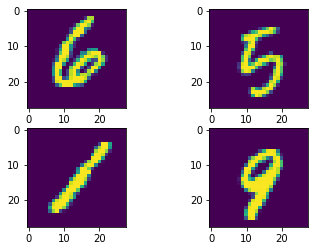

In [9]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

## 3. Model Construction

VAE has three basic parts

1. Encoder: that learns the parameters (mean and the varaince) of the underlying low dimensional latent distribution of the original high dimensional Input Image

2. A sampling function tht samples from the distribution

3. A decoder that can turn the sample data from the learned distribution and coverts it to highdimensional Output data

In this example both the encoder and the decoder are CNNs.

####  A. Encodr Network

The encoder has two output layers, one for the latent distribution mean and teh other for its variance

In [29]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2 # number of latent ddimensions

# encoder Architeccture:
#Input >> Conv2d*4 >> Flatten >> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)

# need to know the shape of the network here for the decoder 
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)

# two outputs: Latent mean and (log) variance
z_mu = layers.Dense(2)(x)
z_log_sigma = layers.Dense(2)(x) #note that the inut is 'x' but not 'z_mu'

#### B. Sampling Function

This function samples the data from the sampling distribution learned by the encoder (the parameters learned: z_mu, z_log_sigma). $epsilon$ is a tensor of small random normal values. One of the assumptions underlying a VAE is that the data came from random normal distribution in latent space. 

With keras everything has to be in a layer format to compile correctly. This goes for the sampling function too. The lambda wrapper can be used for this operation

In [30]:
# sampling function
def sampling(args):
    
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma)*epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

#### C. Decoder Network
the deoder is baically the inverse of the encoder

In [32]:
# decoder takes the latent distribution sample 'Z' as input 

decoder_input = layers.Input(K.int_shape(z)[1:])

#expanding to 784 pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

#reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the cov layers from the encoder
x = layers.Conv2DTranspose(32,3,padding='same',activation='relu',
                          strides=(2,2))(x)

x = layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)

#decoder model statement
decoder = Model(decoder_input,x)

# apply the decoder to the sample from the latent space
z_decoded = decoder(z)

#### D. Loss function

VAE requires a unique loss function. VAE is trained using a loss function with two components

1. **Reconstruction Loss**: This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.

2. **The KL-divergence**: it is between the latent distribution and the prior (this acts a sort of regulaization term)

We define a custom layer class that calculates the loss

In [34]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        #x is input (true) and z_decoded is reconst image (predicted) 
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        #reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x,z_decoded)
        
        # KL divergence
        kl_loss = -5e-4*K.mean(1+z_log_sigma - K.square(z_mu)-K.exp(z_log_sigma),axis=-1)
        
        return K.mean(xent_loss+kl_loss)
    
    def call(self,inputs):
        
        x = inputs[0]           #actual image
        z_decoded = inputs[1]   # predicted image
        my_loss = self.vae_loss(x,z_decoded)
        
        # define the loss function to the layer
        self.add_loss(my_loss, inputs=inputs) 
        
        return x
        
# apply the custom loss to the  input images and the decoded
# latent distribution
    
y = CustomVariationalLayer()([input_img, z_decoded])

W0330 00:15:45.546758 11008 deprecation_wrapper.py:119] From C:\Users\Navyanth\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0330 00:15:45.562785 11008 deprecation.py:323] From C:\Users\Navyanth\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instatiate teh model and take a look at the summry

In [35]:
# VAE model statement
vae = Model(input_img, y)

In [36]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 28, 28, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_44 

In [37]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


## 4. Train the VAE

In [ ]:
vae.fit(x=X_train, y=None, shuffle=True, epochs=7,
       batch_size=batch_size, validation_data=(X_valid,None))